Codebase forked from starter code from CSE490G (Deep Learning)

If code has been borrowed or adapted elsewhere, a link to the source and guide on why that code works the way it does is included as a comment in the codebase.

# Set up the environment

In [ ]:
from google.colab import drive
drive.mount('/gdrive/', force_remount=False)
!ls /gdrive

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
MyDrive  Shareddrives


In [ ]:
!pip install daltonize

In [ ]:
import os

BASE_PATH = '/gdrive/My Drive/colab_files/colorvision/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !rm homework2.tar
!pwd
!ls
os.chdir('/content')

/content
sample_data
/gdrive/My Drive/colab_files/colorvision
pt_util.py  __pycache__  tiny_imagenet


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util
import random
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from daltonize import daltonize
import pickle
import cv2

# Set up dataset and model structures

In [ ]:
# # Show the previews of what the filters look like
# temp_images = h5py.File(DATA_PATH + 'train.h5', 'r')['images'][:]
# show_bounds = random.randint(0, len(temp_images)-5)

# print('regular')
# temp_disp_images = np.array([np.rint(temp_images[i]).astype(np.uint8) for i in range(show_bounds,show_bounds+5)])
# pt_util.show_images(temp_disp_images, [f'img{i}' for i in range(len(temp_images))])
# print('simulate : deuteronopia')
# temp_disp_images = np.array([np.rint(daltonize.simulate(temp_images[i], color_deficit='d')).astype(np.uint8) for i in range(show_bounds,show_bounds+5)])
# pt_util.show_images(temp_disp_images, [f'img{i}' for i in range(len(temp_images))])
# print('simulate : protonapia')
# temp_disp_images = np.array([np.rint(daltonize.simulate(temp_images[i], color_deficit='p')).astype(np.uint8) for i in range(show_bounds,show_bounds+5)])
# pt_util.show_images(temp_disp_images, [f'img{i}' for i in range(len(temp_images))])
# print('simulate : tritanopia')
# temp_disp_images = np.array([np.rint(daltonize.simulate(temp_images[i], color_deficit='t')).astype(np.uint8) for i in range(show_bounds,show_bounds+5)])
# pt_util.show_images(temp_disp_images, [f'img{i}' for i in range(len(temp_images))])

In [ ]:
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, rgbfilter=None, transform=None):
        self.rgbfilter = rgbfilter
        self.transform = transform
        self.h5_file = h5py.File(h5_file, 'r')
        self.images = self.h5_file['images'][:]
        self.labels = torch.LongTensor(self.h5_file['labels'][:])
        
    def __len__(self):
        return self.labels.shape[0]
      
    def __getitem__(self, idx):
        if self.rgbfilter:
            # rgbfilter should be either d, p, t
            data = np.rint(daltonize.simulate(self.images[idx], color_deficit=self.rgbfilter)).astype(np.uint8)
        else:
            data = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        return (data.float(), label)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
])
train_transforms_grayscale = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
])
test_transforms_grayscale = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
])

# data_train = H5Dataset(DATA_PATH + 'train.h5', rgbfilter=None, transform=train_transforms)
# # There are 100000 training data points in the dataset.
# print(len(data_train))
# data_test = H5Dataset(DATA_PATH + 'val.h5', rgbfilter=None, transform=test_transforms)
# # There are 8000 training data points in the dataset.
# print(len(data_test))
# # There are 200 image classes in the dataset.
# print(len(set([int(data_test[i][1][0]) for i in range(len(data_test))]))

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 5, stride=2, padding=1)
        self.fc1 = nn.Linear(3136, 200)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [ ]:
class ComplexNet(nn.Module):
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.mp = nn.MaxPool2d(3, stride=2, padding=1)
        self.dropout = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.conv6_bn = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 1024, 3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(1024, 2048, 3, stride=2, padding=1)
        self.conv8_bn = nn.BatchNorm2d(2048)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,200)
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = self.dropout(x)
        X = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.conv6_bn(x)
        x= F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = self.conv8_bn(x)
        x = self.mp(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# Train the model(s)

In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy

In [ ]:
default_experiment_settings = {
    'model': 'simple',
    'filter': 'tri',
}
def run_experiment(experiment_name, experiment_settings=default_experiment_settings):
    # Play around with these constants, you may find a better setting.
    BATCH_SIZE = 512
    TEST_BATCH_SIZE = 20
    EPOCHS = 50
    LEARNING_RATE = 0.01
    MOMENTUM = 0.9
    USE_CUDA = True
    SEED = 0
    PRINT_INTERVAL = 100
    WEIGHT_DECAY = 0.0005

    EXPERIMENT_VERSION = str(experiment_name)
    LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

    # Now the actual training code
    use_cuda = USE_CUDA and torch.cuda.is_available()

    #torch.manual_seed(SEED)

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    print('num cpus:', multiprocessing.cpu_count())

    kwargs = {'num_workers': multiprocessing.cpu_count(),
              'pin_memory': True} if use_cuda else {}

    class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
    name_to_class = {line[1]: line[0] for line in class_names}
    class_names = [line[1] for line in class_names]

    if experiment_settings['filter'] == 'tri':
        data_train = H5Dataset(DATA_PATH + 'train.h5', rgbfilter=None, transform=train_transforms)
        data_test = H5Dataset(DATA_PATH + 'val.h5', rgbfilter=None, transform=test_transforms)
    elif experiment_settings['filter'] == 'bi-d':
        data_train = H5Dataset(DATA_PATH + 'train.h5', rgbfilter='d', transform=train_transforms)
        data_test = H5Dataset(DATA_PATH + 'val.h5', rgbfilter='d', transform=test_transforms)
    elif experiment_settings['filter'] == 'bi-p':
        data_train = H5Dataset(DATA_PATH + 'train.h5', rgbfilter='p', transform=train_transforms)
        data_test = H5Dataset(DATA_PATH + 'val.h5', rgbfilter='p', transform=test_transforms)
    elif experiment_settings['filter'] == 'bi-t':
        data_train = H5Dataset(DATA_PATH + 'train.h5', rgbfilter='t', transform=train_transforms)
        data_test = H5Dataset(DATA_PATH + 'val.h5', rgbfilter='t', transform=test_transforms)
    elif experiment_settings['filter'] == 'grey':
        data_train = H5Dataset(DATA_PATH + 'train.h5', rgbfilter=None, transform=train_transforms_grayscale)
        data_test = H5Dataset(DATA_PATH + 'val.h5', rgbfilter=None, transform=test_transforms_grayscale)
    else:
        raise ValueError('invalid filter setting')

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                              shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)
    
    if experiment_settings['model'] == 'simple':
        model = SimpleNet().to(device)
    elif experiment_settings['model'] == 'complex':
        model = ComplexNet().to(device)
    else:
        raise ValueError('invalid model setting')
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(LOG_PATH)

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
    test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
        error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
        pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
        pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


In [ ]:
# Train our models on different color datasets

# run_experiment('simple-tri-0',  experiment_settings={'model': 'simple', 'filter': 'tri',})
# run_experiment('simple-d-0',    experiment_settings={'model': 'simple', 'filter': 'bi-d',})
# run_experiment('simple-p-0',    experiment_settings={'model': 'simple', 'filter': 'bi-p',})
# run_experiment('simple-t-0',    experiment_settings={'model': 'simple', 'filter': 'bi-t',})
# run_experiment('simple-grey-0', experiment_settings={'model': 'simple', 'filter': 'grey',})

# run_experiment('complex-tri-0',  experiment_settings={'model': 'complex', 'filter': 'tri',})
# run_experiment('complex-d-0',    experiment_settings={'model': 'complex', 'filter': 'bi-d',})
# run_experiment('complex-p-0',    experiment_settings={'model': 'complex', 'filter': 'bi-p',})
# run_experiment('complex-t-0',    experiment_settings={'model': 'complex', 'filter': 'bi-t',})
# run_experiment('complex-grey-0', experiment_settings={'model': 'complex', 'filter': 'grey',})

# Score models on trichromatic data

In [ ]:
def score_tricolor(experiment_name):
    # evaluate the model on tricolor data
    TEST_BATCH_SIZE = 20
    USE_CUDA = True
    EXPERIMENT_VERSION = str(experiment_name)
    LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

    import multiprocessing
    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': multiprocessing.cpu_count(),
              'pin_memory': True} if use_cuda else {}

    class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
    name_to_class = {line[1]: line[0] for line in class_names}
    class_names = [line[1] for line in class_names]

    if experiment_name[:6] == 'simple':
        model = SimpleNet().to(device)
    else:
        model = ComplexNet().to(device)
    
    # load the model
    # use this if overfitting frequently happens
    checkpoints = sorted(glob.glob(LOG_PATH + '/*.pt'), key=os.path.getmtime)
    start_epoch = model.load_model(checkpoints[0])
    # use the epoch-50 model
    # start_epoch = model.load_last_model(LOG_PATH)

    # load the dataset
    data_test = H5Dataset(DATA_PATH + 'val.h5', rgbfilter=None, transform=test_transforms)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

    return

In [ ]:
# calculate the test accuracy and loss if we run all the models on tricolor data

# score_tricolor('simple-tri-0')
# score_tricolor('simple-d-0')
# score_tricolor('simple-p-0')
# score_tricolor('simple-t-0')
# score_tricolor('simple-grey-0')

# score_tricolor('complex-tri-0')
# score_tricolor('complex-d-0')
# score_tricolor('complex-p-0')
# score_tricolor('complex-t-0')
# score_tricolor('complex-grey-0')

# Visualize 0th-convlayer kernels

In [ ]:
def visualize_kernels(experiment_name, normalize=True):
    # visualize the normalized kernel parameters as an RGB image
    USE_CUDA = True
    EXPERIMENT_VERSION = str(experiment_name)
    LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if experiment_name[:6] == 'simple':
        model = SimpleNet().to(device)
    else:
        model = ComplexNet().to(device)
    
    # load the model and grab weights
    # use this if overfitting frequently happens
    checkpoints = sorted(glob.glob(LOG_PATH + '/*.pt'), key=os.path.getmtime)
    start_epoch = model.load_model(checkpoints[0])
    # use the epoch-50 model
    # start_epoch = model.load_last_model(LOG_PATH)
    
    # only visualizing conv1 directly makes sense
    # since later layers only use conv1 output and aren't rgb at all anymore
    kernels = model.conv1.weight.cpu().detach()

    # normalize the kernel weights to avoid clipping
    if normalize:
        kernels = kernels - kernels.min()
        kernels = kernels / kernels.max()

    # actually render the kernels
    dim_x = 2
    dim_y = int(kernels.size(0) / dim_x)
    scale = 2
    fig, axarr = plt.subplots(dim_x, dim_y, figsize=(dim_y*scale,dim_x*scale))
    for idx in range(kernels.size(0)):
        axarr[int(idx/dim_y)][idx%dim_y].axis('off')
        axarr[int(idx/dim_y)][idx%dim_y].imshow(tf.transpose(kernels[idx]))

In [ ]:
# visualize_kernels('simple-tri-0')
# visualize_kernels('simple-d-0')
# visualize_kernels('simple-p-0')
# visualize_kernels('simple-t-0')
# visualize_kernels('simple-grey-0')

# visualize_kernels('complex-tri-0')
# visualize_kernels('complex-d-0')
# visualize_kernels('complex-p-0')
# visualize_kernels('complex-t-0')
# visualize_kernels('complex-grey-0')

# DeepDream-Like Visualization

In [ ]:
# class to compute image gradients in pytorch
class RGBgradients(nn.Module):
    def __init__(self, weight): # weight is a numpy array
        super().__init__()
        k_height, k_width = weight.shape[1:]
        # assume that the height and width of the kernel are always odd numbers
        padding_x = int((k_height-1)/2)
        padding_y = int((k_width-1)/2)
        
        # convolutional layer with 3 in_channels and 6 out_channels 
        # the 3 in_channels are the color channels of the image
        # for each in_channel we have 2 out_channels corresponding to the x and the y gradients
        self.conv = nn.Conv2d(3, 6, (k_height, k_width), bias = False, 
                              padding = (padding_x, padding_y) )
        # initialize the weights of the convolutional layer to be the one provided
        # the weights correspond to the x/y filter for the channel in question and zeros for other channels
        # x-derivative for 1st in_channel
        weight1x = np.array([weight[0], 
                             np.zeros((k_height, k_width)),
                             np.zeros((k_height, k_width))])
        # y-derivative for 1st in_channel
        weight1y = np.array([weight[1], 
                             np.zeros((k_height, k_width)), 
                             np.zeros((k_height, k_width))])
        # x-derivative for 2nd in_channel
        weight2x = np.array([np.zeros((k_height, k_width)),
                             weight[0],
                             np.zeros((k_height, k_width))])
        # y-derivative for 2nd in_channel
        weight2y = np.array([np.zeros((k_height, k_width)), 
                             weight[1],
                             np.zeros((k_height, k_width))])
        # x-derivative for 3rd in_channel
        weight3x = np.array([np.zeros((k_height, k_width)),
                             np.zeros((k_height, k_width)),
                             weight[0]])
        # y-derivative for 3rd in_channel
        weight3y = np.array([np.zeros((k_height, k_width)),
                             np.zeros((k_height, k_width)), 
                             weight[1]])
        
        weight_final = torch.from_numpy(np.array([weight1x, weight1y, 
                                                  weight2x, weight2y,
                                                  weight3x, weight3y])).type(torch.FloatTensor)
        
        if self.conv.weight.shape == weight_final.shape:
            self.conv.weight = nn.Parameter(weight_final)
            self.conv.weight.requires_grad_(False)
        else:
            print('Error: The shape of the given weights is not correct')
    
    # Note that a second way to define the conv. layer here would be to pass group = 3 when calling torch.nn.Conv2d
    
    def forward(self, x):
        return self.conv(x)

In [50]:
def visualize_like_deep_dream(experiment_name, layer_name, layer_neuron_number, kernel_dim):
    # visualize the normalized kernel parameters as an RGB image
    USE_CUDA = True
    EXPERIMENT_VERSION = str(experiment_name)
    LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

    use_cuda = USE_CUDA and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if experiment_name[:6] == 'simple':
        model = SimpleNet().to(device)
    else:
        model = ComplexNet().to(device)

    # load the model and grab weights
    # use this if overfitting frequently happens
    checkpoints = sorted(glob.glob(LOG_PATH + '/*.pt'), key=os.path.getmtime)
    start_epoch = model.load_model(checkpoints[0])
    # use the epoch-50 model
    # start_epoch = model.load_last_model(LOG_PATH)

    # Visualization guided by
    # https://medium.com/analytics-vidhya/deep-dream-visualizing-the-features-learnt-by-convolutional-networks-in-pytorch-b7296ae3b7f

    # Freeze the model parameters, we don't want to modify these
    for param in model.parameters():
        param.requires_grad_(False)

    # dictionary to store the activation of a layer
    activation = {} 
    def create_hook(name):
        def hook(m, i, o):
            # copy the output of the given layer
            activation[name] = o

        return hook

    # register forward hook
    print(layer_name == 'fc1')
    if layer_name == 'conv1':
        model.conv1.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'conv2':
        model.conv2.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'conv3':
        model.conv3.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'conv4':
        model.conv4.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'conv5':
        model.conv5.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'conv6':
        model.conv6.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'conv7':
        model.conv7.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'conv8':
        model.conv8.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'fc1':
        model.fc1.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'fc2':
        model.fc2.register_forward_hook(create_hook(layer_name))
    elif layer_name == 'fc3':
        model.fc3.register_forward_hook(create_hook(layer_name))
    else:
        raise ValueError('wtf are you doing')

    # define the image normalization and de-normalization functions
    # normalize the input image to have appropriate mean and standard deviation as specified by pytorch
    # also define an inverse operation when we need that :)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                      std = [1/0.229, 1/0.224, 1/0.225] )

    # generate our initial (static noise) image!
    # generate a numpy array with random values
    # this is the INITIAL dimension to grow from
    img_dim = 32
    img = np.single(np.random.uniform(0.4, 0.6, (3, img_dim, img_dim)))

    # convert to a torch tensor, normalize, set the requires_grad_ flag
    img_tensor = normalize(torch.from_numpy(img)).to(device).requires_grad_(True)

    # function to massage img_tensor for using as input to plt.imshow()
    def image_converter(im):
        
        # move the image to cpu
        im_copy = im.cpu()
        
        # for plt.imshow() the channel-dimension is the last
        # therefore use transpose to permute axes
        im_copy = denormalize(im_copy.clone().detach()).numpy()
        im_copy = im_copy.transpose(1,2,0)
        
        # clip negative values as plt.imshow() only accepts 
        # floating values in range [0,1] and integers in range [0,255]
        im_copy = im_copy.clip(0, 1) 
        
        return im_copy

    if kernel_dim == 3:
        # Scharr filters work well for 3x3 kernels
        filter_x = np.array([[-3, 0, 3], 
                             [-10, 0, 10],
                             [-3, 0, 3]])
        filter_y = filter_x.T
        grad_filters = np.array([filter_x, filter_y])
    elif kernel_dim == 5:
        # Use a 5x5 filter
        # informal source https://stackoverflow.com/questions/9567882/sobel-filter-kernel-of-large-size
        filter_x = np.array([[-5, -4, 0, 4, 5], 
                             [-8, -10, 0, 10, 8],
                             [-10, -20, 0, 20, 10],
                             [-8, -10, 0, 10, 8],
                             [-5, -4, 0, 4, 5]])
        filter_y = filter_x.T
        grad_filters = np.array([filter_x, filter_y])
    else:
        raise ValueError('invalid or unsupported kernel dimension; implement?')
    gradLayer = RGBgradients(grad_filters)

    # function to compute gradient loss of an image
    def grad_loss(img, beta = 1, device = 'cpu'):
        # move the gradLayer to cuda
        gradLayer.to(device)
        gradSq = gradLayer(img.unsqueeze(0))**2
        grad_loss = torch.pow(gradSq.mean(), beta/2)
        return grad_loss

    # Hyperparameters for image gradienting
    # the neuron to visualize
    unit_idx = layer_neuron_number
    # factor by which to weigh the activation relative to the regulizer terms
    act_wt = 0.5
    # no. of times to upscale
    upscaling_steps = 36
    upscaling_factor = 1.05
    # no. of times to optimize an input image before upscaling
    optim_steps = 20
    noise = 0.1

    # Now actually do the image gradienting!
    model.eval()
    for mag_epoch in range(upscaling_steps+1):
        optimizer = optim.Adam([img_tensor], lr = 0.4)
        
        for opt_epoch in range(optim_steps):
            optimizer.zero_grad()
            # print(tf.shape(img_tensor.detach().cpu()))
            model(img_tensor.unsqueeze(0))
            layer_out = activation[layer_name]
            rms = torch.pow((layer_out[0, unit_idx]**2).mean(), 0.5)
            # terminate if rms is nan
            if torch.isnan(rms):
                print('Error: rms was NaN; Terminating ...')
                sys.exit()
            
            # pixel intensity
            pxl_inty = torch.pow((img_tensor**2).mean(), 0.5)
            # terminate if pxl_inty is nan
            if torch.isnan(pxl_inty):
                print('Error: Pixel Intensity was NaN; Terminating ...')
                sys.exit()
                
            # image gradients
            im_grd = grad_loss(img_tensor, beta = 1, device = device)
            # terminate is im_grd is nan
            if torch.isnan(im_grd):
                print('Error: image gradients were NaN; Terminating ...')
                sys.exit()
            
            loss = -act_wt*rms + pxl_inty + im_grd        
            # print activation at the beginning of each mag_epoch
            if opt_epoch == 0:
                print('begin mag_epoch {}, activation: {}'.format(mag_epoch, rms))
            loss.backward()
            optimizer.step()
            
        # view the result of optimising the image
        print('end mag_epoch: {}, activation: {}'.format(mag_epoch, rms))
        img = image_converter(img_tensor)
        last_output_img = img
        plt.imshow(img)
        plt.title('image at the end of mag_epoch: {}'.format(mag_epoch))
        plt.show()
        
        # upscale the image
        # also move the batch axis to be the first
        img = cv2.resize(img, dsize = (0,0), 
                        fx = upscaling_factor, fy = upscaling_factor).transpose(2,0,1)
        img_tensor = normalize(torch.from_numpy(img)).to(device).requires_grad_(True)
    
    return last_output_img, rms

In [ ]:
class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

name_to_class.keys()

dict_keys(['goldfish', 'European fire salamander', 'bullfrog', 'tailed frog', 'American alligator', 'boa constrictor', 'trilobite', 'scorpion', 'black widow', 'tarantula', 'centipede', 'goose', 'koala', 'jellyfish', 'brain coral', 'snail', 'slug', 'sea slug', 'American lobster', 'spiny lobster', 'black stork', 'king penguin', 'albatross', 'dugong', 'Chihuahua', 'Yorkshire terrier', 'golden retriever', 'Labrador retriever', 'German shepherd', 'standard poodle', 'tabby', 'Persian cat', 'Egyptian cat', 'cougar', 'lion', 'brown bear', 'ladybug', 'fly', 'bee', 'grasshopper', 'walking stick', 'cockroach', 'mantis', 'dragonfly', 'monarch', 'sulphur butterfly', 'sea cucumber', 'guinea pig', 'hog', 'ox', 'bison', 'bighorn', 'gazelle', 'Arabian camel', 'orangutan', 'chimpanzee', 'baboon', 'African elephant', 'lesser panda', 'abacus', 'academic gown', 'altar', 'apron', 'backpack', 'bannister', 'barbershop', 'barn', 'barrel', 'basketball', 'bathtub', 'beach wagon', 'beacon', 'beaker', 'beer bottle

In [ ]:
# %%capture
# # don't want to show output for this cell, it lags out colab
# deepdreams = {}
# for imagetype in name_to_class.keys():
#     class_to_visualize = imagetype
#     img, rms = visualize_like_deep_dream('complex-tri-0', 'fc3', int(name_to_class[class_to_visualize]), 3)
#     deepdreams[imagetype] = (rms, img)

# # checkpoint / save these! :)
# pickle.dump(deepdreams, open(DATA_PATH + 'deepdreams-tri.pkl', 'wb'))

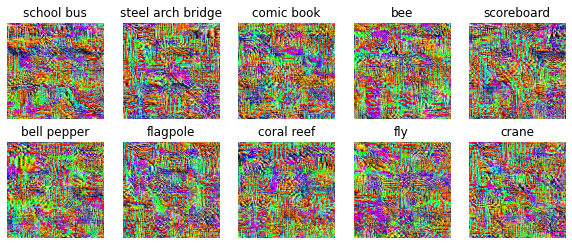

In [45]:
deepdreams = pickle.load(open(DATA_PATH + 'deepdreams-tri.pkl', 'rb'))
sorted_deepdreams = [(e, deepdreams[e][0], deepdreams[e][1]) for e in deepdreams]
sorted_deepdreams.sort(key=lambda e: e[1], reverse=True)

top_ten_classes = []

dim_x = 2
dim_y = 5
scale = 2
fig, axarr = plt.subplots(dim_x, dim_y, figsize=(dim_y*scale,dim_x*scale))
for i in range(10):
    axarr[int(i/dim_y)][i%dim_y].axis('off')
    axarr[int(i/dim_y)][i%dim_y].title.set_text(sorted_deepdreams[i][0])
    axarr[int(i/dim_y)][i%dim_y].imshow(sorted_deepdreams[i][2])
    top_ten_classes.append(sorted_deepdreams[i][0])

In [51]:
%%capture
# don't want to show output for this cell, it lags out colab

comparable_top_ten = {}

for class_to_visualize in top_ten_classes:
    for modelname in ['complex-d-0', 'complex-p-0', 'complex-t-0', 'complex-grey-0']:
        img, rms = visualize_like_deep_dream(modelname, 'fc3', int(name_to_class[class_to_visualize]), 3)
        comparable_top_ten[(class_to_visualize, modelname)] = (rms, img)

pickle.dump(comparable_top_ten, open(DATA_PATH + 'deepdreams-compared.pkl', 'wb'))

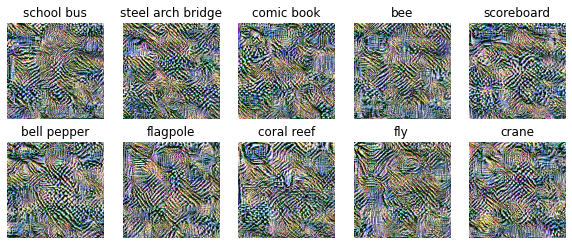

In [76]:
comparable_top_ten = pickle.load(open(DATA_PATH + 'deepdreams-compared.pkl', 'rb'))

modelname = 'complex-grey-0'

dim_x = 2
dim_y = 5
scale = 2
fig, axarr = plt.subplots(dim_x, dim_y, figsize=(dim_y*scale,dim_x*scale))
for i in range(10):
    axarr[int(i/dim_y)][i%dim_y].axis('off')
    axarr[int(i/dim_y)][i%dim_y].title.set_text(top_ten_classes[i])
    axarr[int(i/dim_y)][i%dim_y].imshow(comparable_top_ten[(top_ten_classes[i], modelname)][1])

In [69]:
%%capture
# don't want to show output for this cell, it lags out colab
convdreams = {}
for i in range(2):
    conv_name = f'conv{i+1}'
    convdreams[conv_name] = {}
    for filternumber in range(16 * pow(2, i)):
        img, rms = visualize_like_deep_dream('complex-grey-0', conv_name, filternumber, 3)
        convdreams[conv_name][filternumber] = (rms, img)

pickle.dump(convdreams, open(DATA_PATH + 'convdreams-grey.pkl', 'wb'))

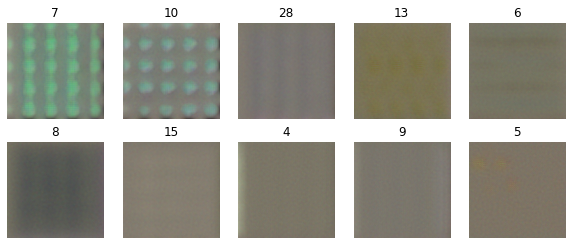

In [72]:
convlayer = 'conv2'

convdreams = pickle.load(open(DATA_PATH + 'convdreams-grey.pkl', 'rb'))
num_neurons = len(convdreams[convlayer])
sorted_convdreams_inlayer = [(e, convdreams[convlayer][e][0], convdreams[convlayer][e][1]) for e in convdreams[convlayer]]
sorted_convdreams_inlayer.sort(key=lambda e: e[1], reverse=True)

top_ten_neurons = []

dim_x = 2
dim_y = 5
scale = 2
fig, axarr = plt.subplots(dim_x, dim_y, figsize=(dim_y*scale,dim_x*scale))
for i in range(10):
    axarr[int(i/dim_y)][i%dim_y].axis('off')
    axarr[int(i/dim_y)][i%dim_y].title.set_text(sorted_convdreams_inlayer[i][0])
    axarr[int(i/dim_y)][i%dim_y].imshow(sorted_convdreams_inlayer[i][2])
    top_ten_neurons.append(sorted_convdreams_inlayer[i][0])